# tRNA quantification method comparison

Compare following quantification approaches on same data set, first tRNA seq by Daniel: 2016-08-19-HG3W5AFXX

<p><script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script></p>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>

In [127]:
suppressMessages({
    .libPaths("/g/steinmetz/brooks/anaconda/lib/R/library")
    # config opts and libraries
    options(repr.plot.width = 6)
    options(repr.plot.height = 5)
    options(jupyter.plot_mimetypes = 'image/png')
    library(wasabi)
    library(sleuth)
    library(pheatmap)
    library(forcats) 
    library(LSD)
    library(tidyr)
    library(readr)
    library(reshape2)
})

BASE = "/g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX"
# load ncRNA annotations
allncrnas_final = read_delim("/g/steinmetz/project/IESY/genomes/trnaneo/finalneo_ncRNA_annotations.txt",delim = "\t")
# load previous ncRNA annotations (from v10 neochr)
load("/g/steinmetz/project/IESY/trna/data/ncRNA_annotations.rda")
# find tRNAs present in both versions
common_ncrnas = do.call(rbind,lapply(seq(1,dim(allncrnas)[1]),function(i){
    thisrow = allncrnas[i,]
    if (thisrow$type == "mature_tRNA") {
        # match by sequence
        o = allncrnas_final %>% filter(sequence == thisrow$sequence)
        o = o %>% mutate(oldname = thisrow$Name)
    } else if (thisrow$type == "pre_tRNA") {
        # match by name
        x = paste(strsplit(thisrow$Name, split = "\\.")[[1]][1],
              ".tRNA.*-",
              strsplit(thisrow$Name, split = "\\-")[[1]][2], sep="")
        y = paste(strsplit(thisrow$pair, split = "\\.")[[1]][1],
                  ".tRNA.*-",
                  strsplit(thisrow$pair, split = "\\-")[[1]][2], sep="")
        o = allncrnas_final[grep(x, allncrnas_final$Name),]
        o = o[grep(y, o$pair),]
        o = o %>% mutate(oldname = thisrow$Name)
    } else {
        o = allncrnas_final[grep(thisrow$Name, allncrnas_final$Name),]
        o = o %>% mutate(oldname = thisrow$Name)
    }
    return(o)
}))
common_ncrnas = common_ncrnas %>% distinct()

Parsed with column specification:
cols(
  seqid = col_character(),
  start = col_integer(),
  end = col_integer(),
  Name = col_character(),
  strand = col_character(),
  origin = col_character(),
  sequence = col_character(),
  sequence.leader = col_character(),
  sequence.trnaonly = col_character(),
  sequence.trailer = col_character(),
  type = col_character(),
  pair = col_character(),
  original.name = col_character(),
  final.name = col_character(),
  sgd.name = col_character()
)


## Load Data

### Salmon, quasi

In [128]:
dataf1 = file.path(BASE, "/salmon_align_mode/quasi/2016-08-19-HG3W5AFXX-S1/quant.sf")
salmon_quasi_1 = read_delim(dataf1, delim="\t") %>% mutate(sample = "S1", quanttype = "quasi")
dataf2 = file.path(BASE, "/salmon_align_mode/quasi/2016-08-19-HG3W5AFXX-S2/quant.sf")
salmon_quasi_2 = read_delim(dataf2, delim="\t") %>% mutate(sample = "S2", quanttype = "quasi")
salmon_quasi = rbind(salmon_quasi_1, salmon_quasi_2)

Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)


### Salmon, alignment

In [129]:
dataf1 = file.path(BASE, "/salmon_align_mode/align/2016-08-19-HG3W5AFXX-S1/quant.sf")
salmon_align_1 = read_delim(dataf1, delim="\t") %>% mutate(sample = "S1", quanttype = "align")
dataf2 = file.path(BASE, "/salmon_align_mode/align/2016-08-19-HG3W5AFXX-S2/quant.sf")
salmon_align_2 = read_delim(dataf2, delim="\t") %>% mutate(sample = "S2", quanttype = "align")
salmon_align_small = rbind(salmon_align_1, salmon_align_2)

dataf3 = file.path(BASE, "/salmon_align_mode/align/2016-08-19-HG3W5AFXX-S3/quant.sf")
salmon_align_3 = read_delim(dataf3, delim="\t") %>% mutate(sample = "S3", quanttype = "align")
dataf4 = file.path(BASE, "/salmon_align_mode/align/2016-08-19-HG3W5AFXX-S4/quant.sf")
salmon_align_4 = read_delim(dataf4, delim="\t") %>% mutate(sample = "S4", quanttype = "align")
salmon_align = rbind(salmon_align_1, salmon_align_2, salmon_align_3, salmon_align_4)

sample2ezname = function(x) {
    o = x
    o[x == "S1"] = "BY4741+neo"
    o[x == "S2"] = "BY4741"
    o[x == "S3"] = "triple-syn+neo"
    o[x == "S4"] = "triple-syn"
    return(o)
}
chr2ezname = function(x) {
    o = x
    o[x == "chr17"] = "mito"
    o[x == "chr18"] = "neo"
    return(o)
}

# combine salmon
salmon = rbind(salmon_quasi, salmon_align_small)
salmon$Name.original = salmon$Name
salmon = salmon %>% separate(Name, into = c("origin","Name"),sep = "\\.", extra = "merge", remove = T)
# because of naming, I need to move to mtrans
mtrnas = which(is.na(salmon$Name))
if (length(mtrnas) > 0) {
    salmon$Name[mtrnas] = salmon$origin[mtrnas]
    salmon$origin[mtrnas] = NA
} 
# combine with ncRNA annotations
salmon = merge(salmon, allncrnas_final, by = c("Name","origin"), all = T)
salmon = salmon %>% separate(Name, into = c("tmp1","tmp2"), sep = "-", extra = "merge", remove = F) %>%
    separate(tmp2, into = c("AA","Isotype"), sep = 3, remove = T) %>%
    separate(Isotype, into = c("Isotype","Isotype.Number"), sep = 3, remove = T) %>%
    mutate(mature.trna = ifelse(grepl("tRNA", Name) & !grepl("chr", Name),T,F))
salmon = salmon %>% mutate(ezseqid = chr2ezname(seqid), ezsample = sample2ezname(sample),
                          TPM = as.numeric(TPM), NumReads = as.numeric(NumReads))
salmon$tmp1 = NULL

# combine salmon_align
salmon_align$Name.original = salmon_align$Name
salmon_align = salmon_align %>% separate(Name, into = c("origin","Name"),sep = "\\.", extra = "merge", remove = T)
# because of naming, I need to move to mtrans
mtrnas = which(is.na(salmon_align$Name))
if (length(mtrnas) > 0) {
    salmon_align$Name[mtrnas] = salmon_align$origin[mtrnas]
    salmon_align$origin[mtrnas] = NA
} 
# combine with ncRNA annotations
salmon_align = merge(salmon_align, allncrnas_final, by = c("Name","origin"), all = T)
salmon_align = salmon_align %>% separate(Name, into = c("tmp1","tmp2"), sep = "-", extra = "merge", remove = F) %>%
    separate(tmp2, into = c("AA","Isotype"), sep = 3, remove = T) %>%
    separate(Isotype, into = c("Isotype","Isotype.Number"), sep = 3, remove = T) %>%
    mutate(mature.trna = ifelse(grepl("tRNA", Name) & !grepl("chr", Name),T,F))
salmon_align = salmon_align %>% mutate(ezseqid = chr2ezname(seqid), ezsample = sample2ezname(sample),
                          TPM = as.numeric(TPM), NumReads = as.numeric(NumReads))
salmon_align$tmp1 = NULL

combined = salmon
combined = merge(combined, common_ncrnas %>% select(Name, oldname), by = "Name", all = T) %>% distinct()

Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Warning message:
“Too few values at 592 locations: 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, ...”Warning message:
“Too few values at 592 locations: 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364

### ARMseq

In [4]:
dataf = file.path(BASE, "/armseq/BY4741/BY4741-ARMseq-counts.txt")
armseq = read_delim(dataf, delim="\t", skip = 1, col_names = c("name", "BY4741neo", "BY4741")) %>%
    melt(variable.name = "strain", value.name = "armseq")
armseq = armseq %>% mutate(sample = ifelse(strain == "BY4741neo","S1","S2"),
                          ezsample = ifelse(strain == "BY4741neo","BY4741+neo","BY4741")) %>%
        select("name","sample","ezsample","armseq")
# combined pre and mature tRNAs seperatly
combined1 = merge(combined, armseq %>% filter(!grepl("^tRNA",name)), 
                 by.x = c("Name","sample","ezsample"),
                 by.y = c("name","sample","ezsample"), all = F)
combined2 = merge(combined, armseq %>% filter(!grepl("^tRNA",name)), 
                 by.x = c("oldname","sample","ezsample"),
                 by.y = c("name","sample","ezsample"), all = F)
combined3 = merge(combined, armseq %>% filter(grepl("^tRNA",name)), 
                 by.x = c("oldname","sample","ezsample"),
                 by.y = c("name","sample","ezsample"), all = T)
combined = rbind(combined1,combined2,combined3)

Parsed with column specification:
cols(
  name = col_character(),
  BY4741neo = col_integer(),
  BY4741 = col_integer()
)
Using name as id variables


### TGIRT_map

In [5]:
dataf1 = file.path(BASE, "/tgirt_map/S1/Counts/tRNA_RAW/HG3W5AFXX_tRNANEBNext_16s005526-1-1_Schraivogel_lane1sample1_1_sequence_trimmed.tRNA")
tgirt_1 = read_delim(dataf1, delim="\t", col_names = c("name","count")) %>% mutate(sample = "BY4741neo")
dataf2 = file.path(BASE, "/tgirt_map/S2/Counts/tRNA_RAW/HG3W5AFXX_tRNANEBNext_16s005526-1-1_Schraivogel_lane1sample2_1_sequence_trimmed.tRNA")
tgirt_2 = read_delim(dataf2, delim="\t", col_names = c("name","count")) %>% mutate(sample = "BY4741")
tgirt = rbind(tgirt_1, tgirt_2) %>% separate(name, into = c("tmp1","Name"), sep = "\\.") %>%
    mutate(strain = sample) %>%
    mutate(sample = ifelse(strain == "BY4741neo","S1","S2"),
           ezsample = ifelse(strain == "BY4741neo","BY4741+neo","BY4741"),
           tgirt = count) %>%
    select("Name","sample","ezsample","tgirt")
combined = merge(combined, tgirt, by.x = c("Name","sample","ezsample"), by.y = c("Name","sample","ezsample"), all = T)

Parsed with column specification:
cols(
  name = col_character(),
  count = col_integer()
)
Parsed with column specification:
cols(
  name = col_character(),
  count = col_integer()
)


## Comparison of Salmon in alignment vs quasi modes

## Figure 1: All tRNA species

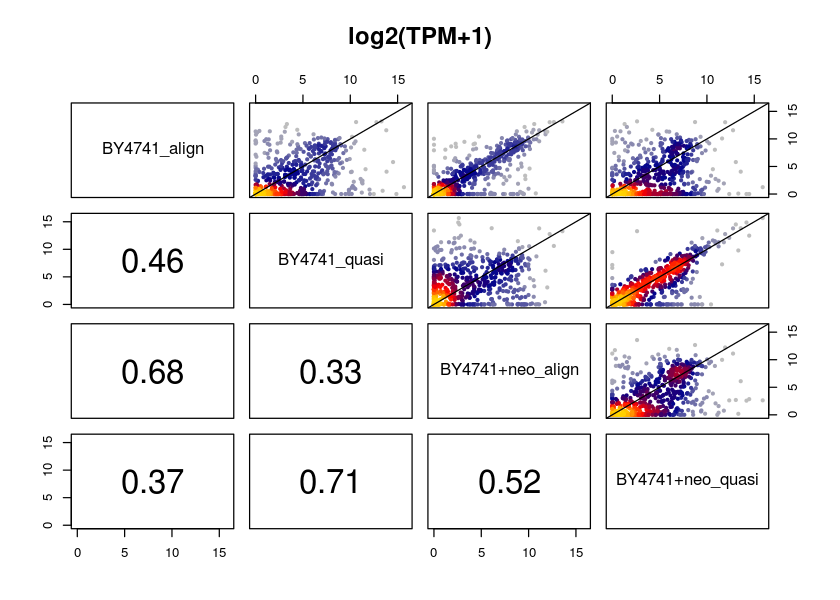

In [6]:
aggresults = acast(salmon %>% filter(grepl("tRNA",Name)), formula = Name ~ ezsample + quanttype, value.var = "TPM", fun.aggregate = median, na.rm = T) 
aggresults = log2(aggresults + 1)
colnames(aggresults) = sample2ezname(colnames(aggresults))
options(repr.plot.width = 7)
options(repr.plot.height = 5)
LSD::heatpairs(aggresults, main = "log2(TPM+1)")

## Figure 2: Mature tRNA species

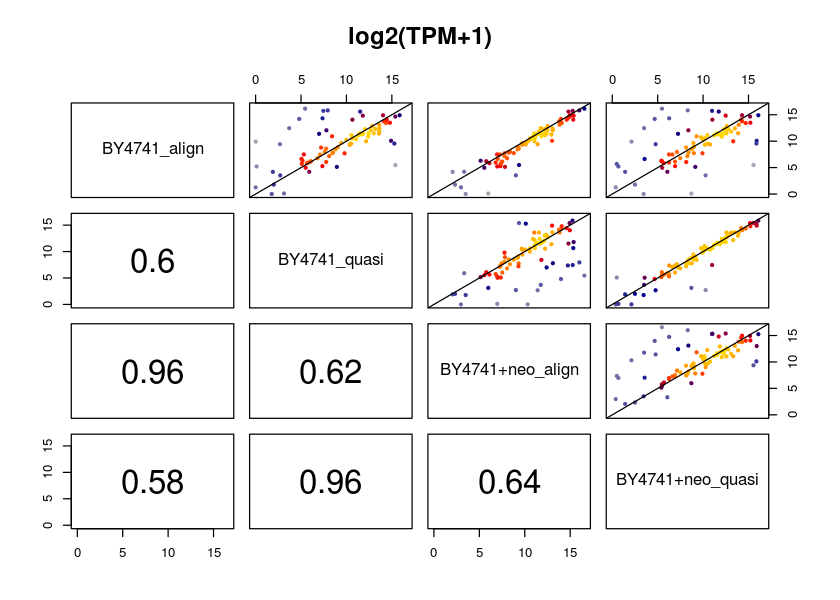

In [7]:
aggresults = acast(salmon %>% filter(grepl("mature",type)), formula = Name ~ ezsample + quanttype, value.var = "TPM", fun.aggregate = median, na.rm = T) 
aggresults = log2(aggresults + 1)
colnames(aggresults) = sample2ezname(colnames(aggresults))
options(repr.plot.width = 7)
options(repr.plot.height = 5)
LSD::heatpairs(aggresults, main = "log2(TPM+1)")

## Figure 3: pre-tRNA species

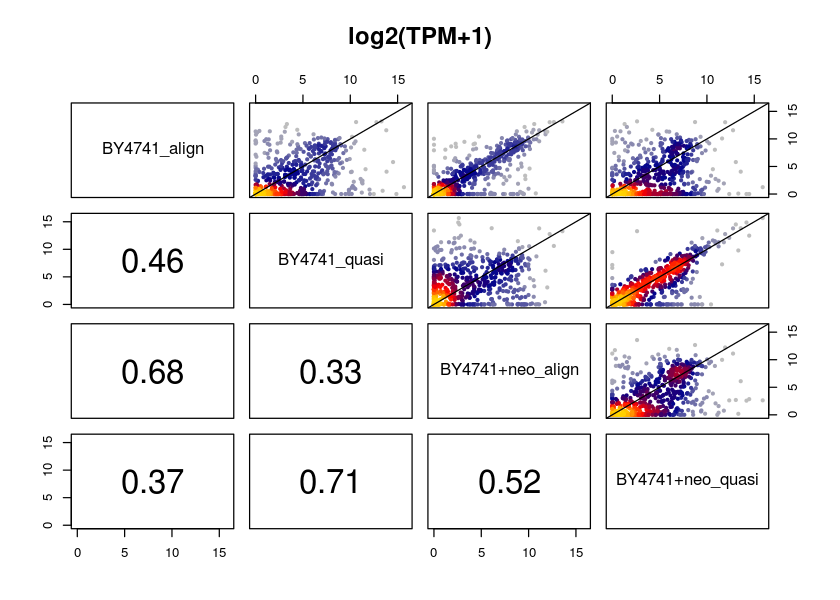

In [8]:
aggresults = acast(salmon %>% filter(grepl("pre",type)), formula = Name ~ ezsample + quanttype, value.var = "TPM", fun.aggregate = median, na.rm = T) 
aggresults = log2(aggresults + 1)
colnames(aggresults) = sample2ezname(colnames(aggresults))
options(repr.plot.width = 7)
options(repr.plot.height = 5)
LSD::heatpairs(aggresults, main = "log2(TPM+1)")

## Figure 4: non-tRNA species

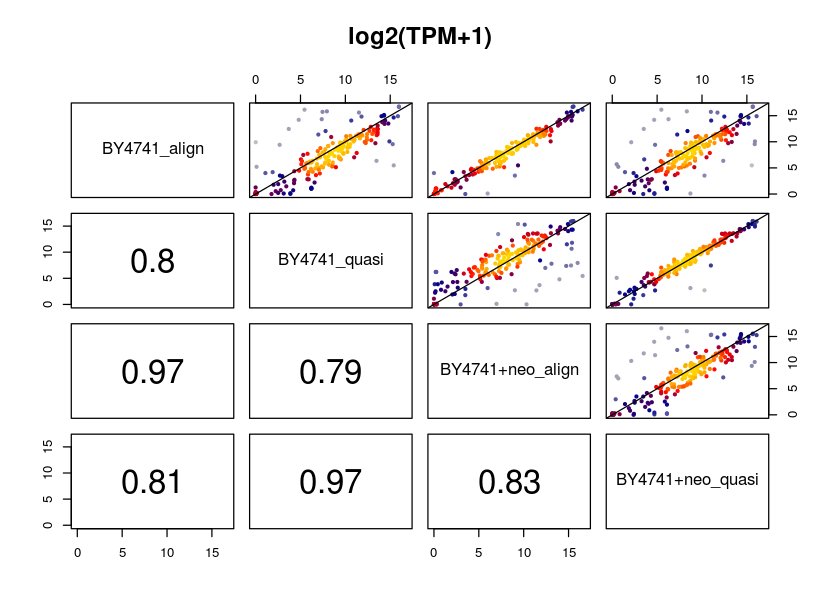

In [9]:
aggresults = acast(salmon %>% filter(!grepl("tRNA",Name)), formula = Name ~ ezsample + quanttype, value.var = "TPM", fun.aggregate = median, na.rm = T) 
aggresults = log2(aggresults + 1)
colnames(aggresults) = sample2ezname(colnames(aggresults))
options(repr.plot.width = 7)
options(repr.plot.height = 5)
LSD::heatpairs(aggresults, main = "log2(TPM+1)")

**Conclusions**: 

- Salmon quantifications in alignment vs quasi modes are different with modest correlation across tRNA species. 
- pre-tRNA quantifications in particular are affected by quantification mode. Mature and non-tRNA species have much higher correlation (e.g. 0.8 vs 0.46)
- Both alignment and quasi quantifiy many pre-tRNAs near zero in strain w/o neochr (more on that later)
- pre-tRNA quantifications are MUCH lower in alignment mode compared to quasi

### Figure 5: TPM vs read counts

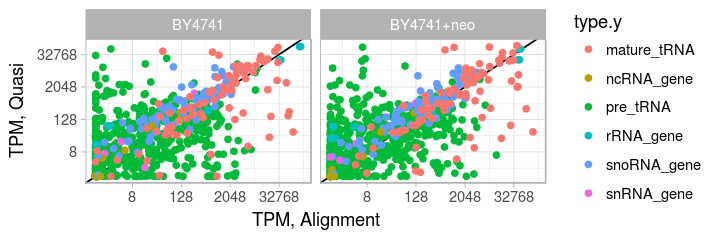

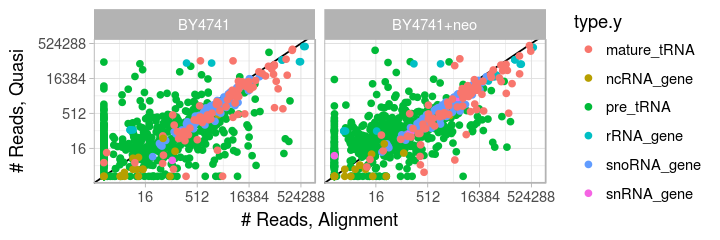

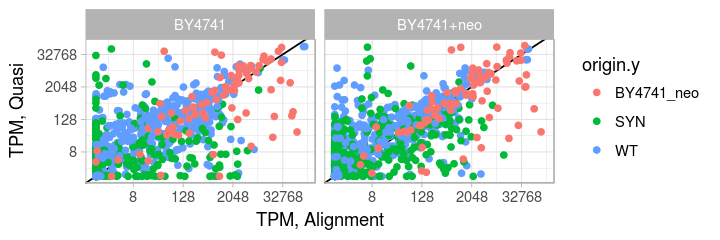

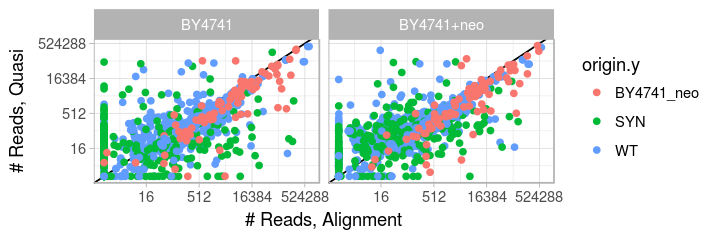

In [10]:
data_modes = merge(filter(salmon,quanttype=="align"), filter(salmon,quanttype=="quasi"), by = c("Name","sample"))
p5.1 <- ggplot(data_modes, aes(x=TPM.x+1,y=TPM.y+1, color=type.y)) + 
    geom_abline(intercept = 0, slope = 1) + 
    geom_point() +
    scale_x_continuous(trans="log2") + scale_y_continuous(trans="log2") + 
    xlab("TPM, Alignment") +
    ylab("TPM, Quasi") +
    facet_wrap(~ezsample.y) +
    theme_light()
p5.2 <- ggplot(data_modes, aes(x=NumReads.x+1,y=NumReads.y+1, color=type.y)) + 
    geom_abline(intercept = 0, slope = 1) + 
    geom_point() +
    scale_x_continuous(trans="log2") + scale_y_continuous(trans="log2") + 
    xlab("# Reads, Alignment") +
    ylab("# Reads, Quasi") +
    facet_wrap(~ezsample.y) +
    theme_light()
p5.3 <- ggplot(data_modes, aes(x=TPM.x+1,y=TPM.y+1, color=origin.y)) + 
    geom_abline(intercept = 0, slope = 1) + 
    geom_point() +
    scale_x_continuous(trans="log2") + scale_y_continuous(trans="log2") + 
    xlab("TPM, Alignment") +
    ylab("TPM, Quasi") +
    facet_wrap(~ezsample.y)  +
    theme_light()
p5.4 <- ggplot(data_modes, aes(x=NumReads.x+1,y=NumReads.y+1, color=origin.y)) + 
    geom_abline(intercept = 0, slope = 1) + 
    geom_point() +
    scale_x_continuous(trans="log2") + scale_y_continuous(trans="log2") + 
    xlab("# Reads, Alignment") +
    ylab("# Reads, Quasi") +
    facet_wrap(~ezsample.y) +
    theme_light()
options(repr.plot.width = 6)
options(repr.plot.height = 2)
p5.1
p5.2
p5.3
p5.4

**Conclusions**: 

- As described above quantification uncertainty greatest for pre-tRNAs
- It would appear that alignment mode has larger number of species on tRNA neochr with correct quantification, i.e. ~0 in BY4741

## Figure 6: Quantification across samples

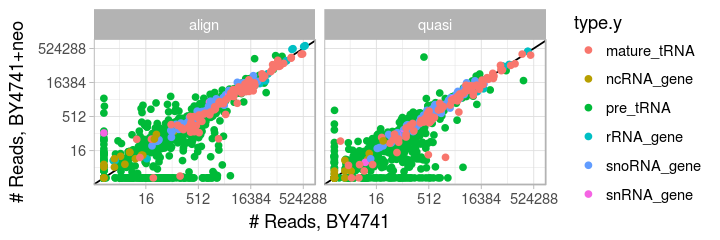

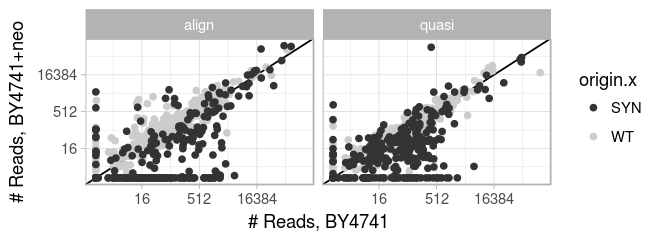

In [85]:
data_samples = merge(filter(salmon,sample=="S1"), filter(salmon,sample=="S2"), by = c("Name","quanttype"))
p6.1 <- ggplot(data_samples, aes(x=NumReads.x+1,y=NumReads.y+1, color=type.y)) + 
    geom_abline(intercept = 0, slope = 1) + 
    geom_point() +
    scale_x_continuous(trans="log2") + scale_y_continuous(trans="log2") + 
    xlab("# Reads, BY4741") +
    ylab("# Reads, BY4741+neo") +
    facet_wrap(~quanttype)+
    theme_light()
p6.2 <- ggplot(data_samples %>% filter(type.x=="pre_tRNA"), aes(x=NumReads.x+1,y=NumReads.y+1, color=origin.x)) + 
    geom_abline(intercept = 0, slope = 1) + 
    geom_point() +
    scale_x_continuous(trans="log2") + scale_y_continuous(trans="log2") + 
    xlab("# Reads, BY4741") +
    ylab("# Reads, BY4741+neo") +
    facet_wrap(~quanttype) +
    scale_color_grey() +
    theme_light()
options(repr.plot.width = 6)
options(repr.plot.height = 2)
p6.1
options(repr.plot.width = 5.5)
options(repr.plot.height = 2)
p6.2

Again looks like the alignment based mapping produces more 0 quantifications for species on the neochr

## Figure 7: Distribution of reads counts

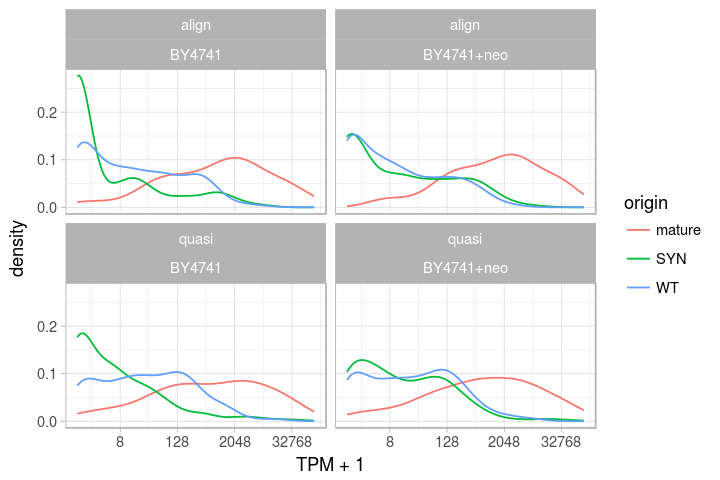

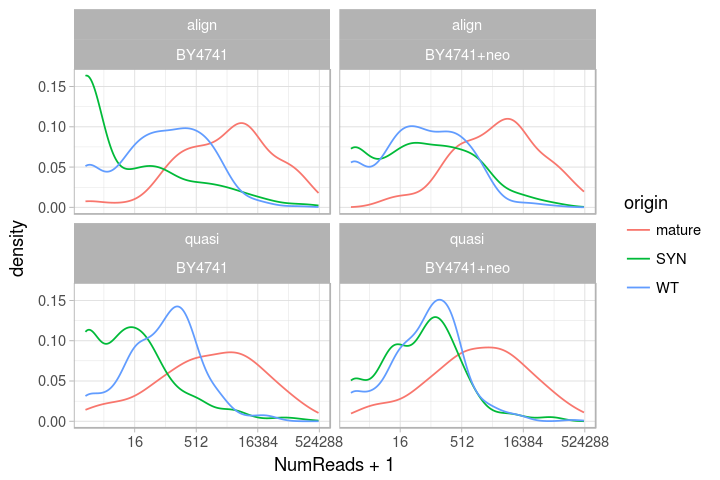

In [12]:
p6.1 <- ggplot(salmon %>% filter(grepl("tRNA",type)) %>% mutate(origin = ifelse(origin=="BY4741_neo","mature",origin)), 
               aes(TPM+1,  color=origin)) + 
    geom_freqpoly(stat ="density") +
    scale_x_continuous(trans="log2") +
    facet_wrap(quanttype~ezsample) +
    theme_light()
p6.2 <- ggplot(salmon %>% filter(grepl("tRNA",type)) %>% mutate(origin = ifelse(origin=="BY4741_neo","mature",origin)), 
               aes(NumReads+1,  color=origin)) + 
    geom_freqpoly(stat ="density") +
    scale_x_continuous(trans="log2") +
    facet_wrap(quanttype~ezsample) +
    theme_light()
options(repr.plot.width = 6)
options(repr.plot.height = 4)
p6.1
p6.2

**Conclusions**

*This is the most important result so far*

This makes the quantification advantage in alignment mode clear. Much higher fraction of pre-tRNAs from the neochr (SYN) are quantified at zero using alignment based quantification. This holds for both TPM and NumReads estimated.

### Figure 8: Effective length

One thing that concerned me previously was long effective length of quasi-alignment. I found that the sometimes astronomical caluclate fragment length relative to real sequence length was associated with mis-quanitfication

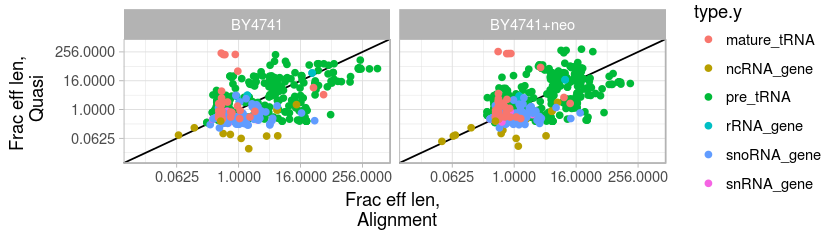

In [13]:
p8 <- ggplot(data_modes, aes(x=EffectiveLength.x/Length.x,y=EffectiveLength.y/Length.y, color=type.y)) + 
    geom_abline(intercept = 0, slope = 1) + 
    geom_point(alpha = 1) +
    scale_x_continuous(trans="log2", limits = c(.01,512)) + scale_y_continuous(trans="log2", limits = c(.01,512)) + 
    xlab("Frac eff len, \n Alignment") +
    ylab("Frac eff len, \n Quasi") +
    facet_wrap(~ezsample.y) +
    theme_light()
options(repr.plot.width = 7)
options(repr.plot.height = 2)
p8

Hard to say if there is much of a difference here. There are extreme outliers on both sides

## Figure 9: Fold-changes

In [86]:
data_foldchange = salmon %>% group_by(quanttype, Name) %>% do({
    this = .
    # s1 is BY4741+neo
    this$FC_TPM = log2(filter(this,sample=="S1")$TPM + 1) - log2(filter(this,sample=="S2")$TPM + 1)
    this$FC_NumReads = log2(filter(this,sample=="S1")$NumReads + 1) - log2(filter(this,sample=="S2")$NumReads + 1)
    this$ezsample = "BY4741+neo/BY4741"
    this$min_NumReads = min(this$NumReads, na.rm = T)
    this$max_NumReads = max(this$NumReads, na.rm = T)
    this = this[1,]
    this
}) %>% ungroup()
data_foldchange_merge = merge(filter(data_foldchange,quanttype=="quasi"),
                        filter(data_foldchange,quanttype=="align"), by = c("Name"))

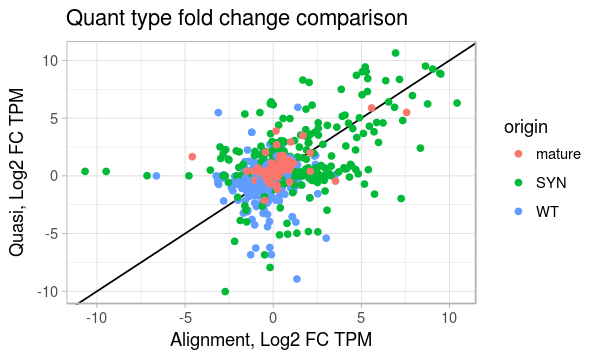

In [87]:
p9 <- ggplot(data_foldchange_merge %>% mutate(origin = ifelse(origin.y=="BY4741_neo","mature",origin.y)), 
             aes(x=FC_TPM.x,y=FC_TPM.y, color=origin)) + 
    geom_abline(intercept = 0, slope = 1) + 
    geom_point(alpha = 1) +
    xlab("Alignment, Log2 FC TPM") +
    ylab("Quasi, Log2 FC TPM") +
    ggtitle("Quant type fold change comparison") +
    theme_light()
options(repr.plot.width = 5)
options(repr.plot.height = 3)
p9

Warning message:
“Removed 84 rows containing non-finite values (stat_density).”

Warning message:
“Removed 133 rows containing non-finite values (stat_density).”

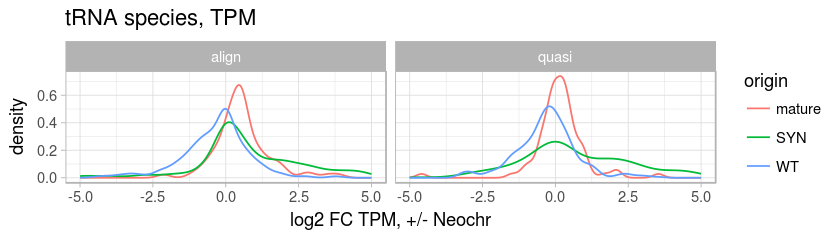

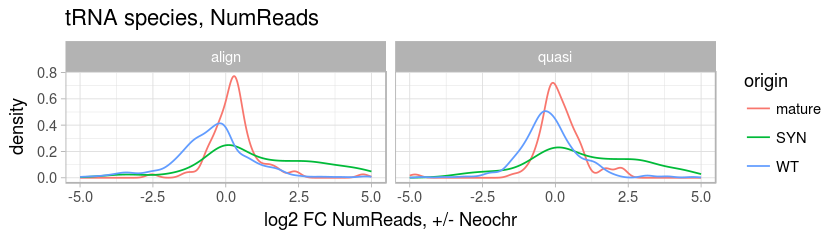

Warning message:
“Removed 1 rows containing non-finite values (stat_density).”

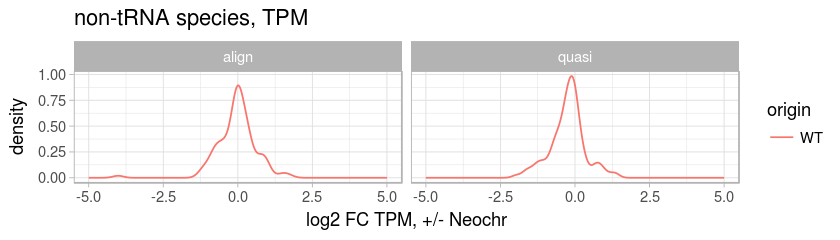

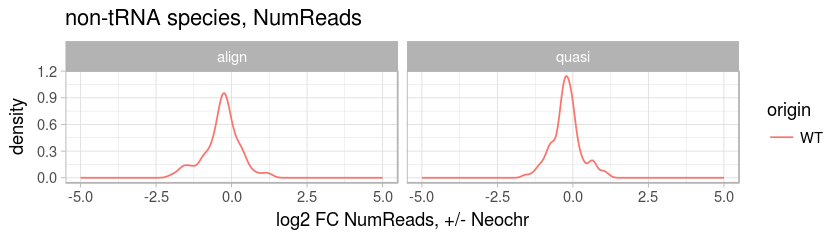

In [88]:
p10.1 <- ggplot(data_foldchange %>% filter(grepl("tRNA",type)) %>% mutate(origin = ifelse(origin=="BY4741_neo","mature",origin)), 
               aes(FC_TPM,  color=origin)) + 
    geom_freqpoly(stat ="density") +
    #geom_vline(xintercept = 1, color="gray") + 
    #scale_x_continuous(trans="log2") +
    facet_wrap(~quanttype) +
    xlab("log2 FC TPM, +/- Neochr") +
    xlim(c(-5,5)) +
    ggtitle("tRNA species, TPM") +
    theme_light()
p10.2 <- ggplot(data_foldchange %>% filter(grepl("tRNA",type)) %>% mutate(origin = ifelse(origin=="BY4741_neo","mature",origin)), 
               aes(FC_NumReads,  color=origin)) + 
    geom_freqpoly(stat ="density") +
    #geom_vline(xintercept = 1, color="gray") + 
    #scale_x_continuous(trans="log2") +
    facet_wrap(~quanttype) +
    xlab("log2 FC NumReads, +/- Neochr") +
    xlim(c(-5,5)) +
    ggtitle("tRNA species, NumReads") +
    theme_light()
p10.3 <- ggplot(data_foldchange %>% filter(!grepl("tRNA",type)) %>% mutate(origin = ifelse(origin=="BY4741_neo","mature",origin)), 
               aes(FC_TPM,  color=origin)) + 
    geom_freqpoly(stat ="density") +
    #geom_vline(xintercept = 1, color="gray") + 
    #scale_x_continuous(trans="log2") +
    facet_wrap(~quanttype) +
    xlab("log2 FC TPM, +/- Neochr") +
    xlim(c(-5,5)) +
    ggtitle("non-tRNA species, TPM") +
    theme_light() 
p10.4 <- ggplot(data_foldchange %>% filter(!grepl("tRNA",type)) %>% mutate(origin = ifelse(origin=="BY4741_neo","mature",origin)), 
               aes(FC_NumReads,  color=origin)) + 
    geom_freqpoly(stat ="density") +
    #geom_vline(xintercept = 1, color="gray") + 
    #scale_x_continuous(trans="log2") +
    facet_wrap(~quanttype) +
    xlab("log2 FC NumReads, +/- Neochr") +
    xlim(c(-5,5)) +
    ggtitle("non-tRNA species, NumReads") +
    theme_light() 
options(repr.plot.width = 7)
options(repr.plot.height = 2)
p10.1
p10.2
p10.3
p10.4

**Conclusions** 

- TPM, which also controls for library size, seems to be a better measure for computing fold change based on near zero mean FC for non-tRNA species
- Mature tRNAs appear to be generaly upregulated in presence of neochr
- pre-tRNAs from the neochr increase in the presence of the neochr. Notable heavy tale and a small shift in the mean. I would expect shift in mean will be greater when we profile the final strain (this strain actually doesn't contain some of the pre-tRNA species that are in the database)
- Also interesting negative FC shift for WT pre-tRNAs in presence of neochr
- Once again alignment based quantification looks better, also seems to be more sensitive to shift in quantification of mature tRNAs

## Figure 12: FC vs ReadCount

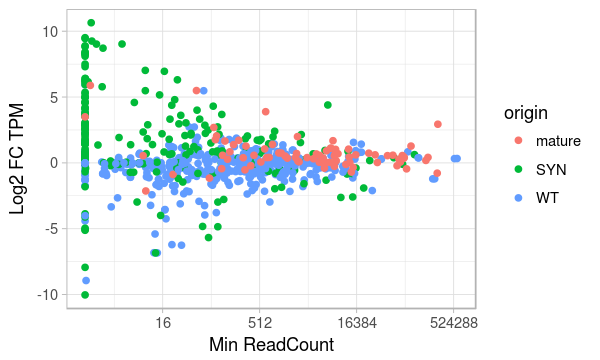

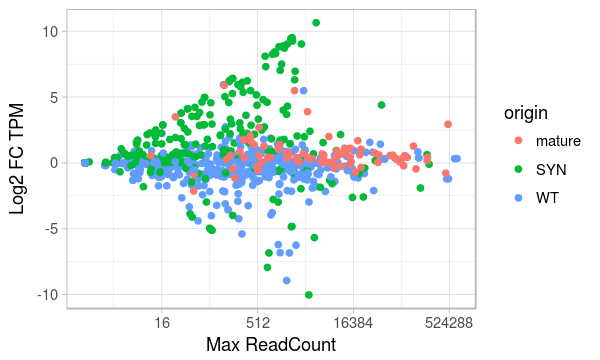

In [100]:
p12.1 <- ggplot(data_foldchange %>% filter(quanttype == "align") %>% 
             mutate(origin = ifelse(origin=="BY4741_neo","mature",origin)), 
             aes(x=min_NumReads+1, y=FC_TPM, color=origin)) + 
    #geom_abline(intercept = 0, slope = 1) + 
    geom_point(alpha = 1) +
    scale_x_continuous(trans="log2") +
    xlab("Min ReadCount") +
    ylab("Log2 FC TPM") +
    theme_light()
p12.2 <- ggplot(data_foldchange %>% filter(quanttype == "align") %>% 
             mutate(origin = ifelse(origin=="BY4741_neo","mature",origin)), 
             aes(x=max_NumReads+1, y=FC_TPM, color=origin)) + 
    #geom_abline(intercept = 0, slope = 1) + 
    geom_point(alpha = 1) +
    scale_x_continuous(trans="log2") +
    xlab("Max ReadCount") +
    ylab("Log2 FC TPM") +
    theme_light()
options(repr.plot.width = 5)
options(repr.plot.height = 3)
p12.1
p12.2

# Compare Salmon align with TGIRT and ARM-seq

## Figure 11: Consensus across all methods (mostly/exclusively mature tRNAs)

TGIRT only quantifies mature tRNAs, so that's all I can compare here

Using Name, ezsample as id variables


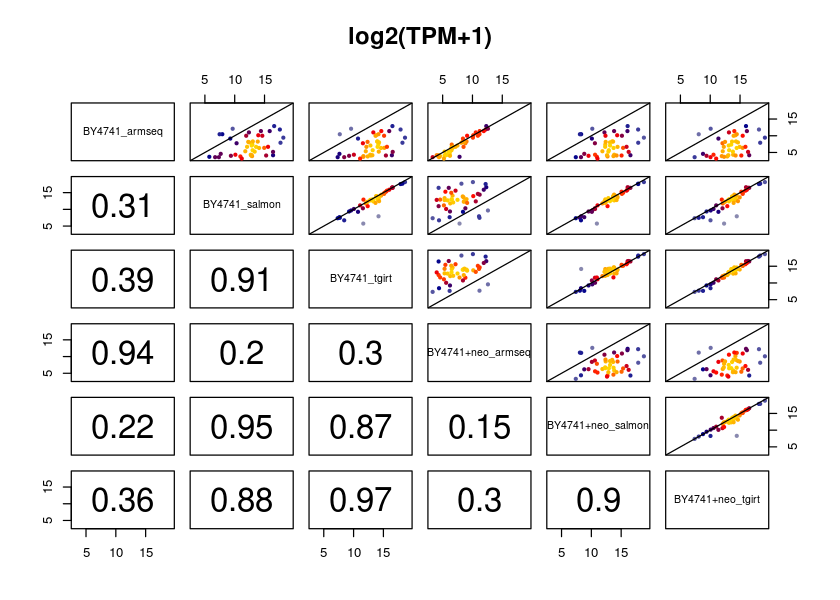

In [106]:
combined_melt = melt(combined %>% filter(quanttype%in%c("align",NA)) %>% select(Name,ezsample,NumReads,armseq,tgirt))
combined_melt = combined_melt %>% mutate(variable = ifelse(variable == "NumReads","salmon",levels(variable)[variable]))
aggresults = acast(combined_melt, formula = Name ~ ezsample + variable, value.var = "value", fun.aggregate = median, na.rm = T) 
aggresults = log2(aggresults + 1)
# only keep complete cases
aggresults = na.omit(aggresults)
colnames(aggresults) = sample2ezname(colnames(aggresults))
options(repr.plot.width = 7)
options(repr.plot.height = 5)
LSD::heatpairs(aggresults, main = "log2(TPM+1)")

** Conclusions ** 

- Salmon-Align and TGIRT correlate well, although TGIRT provides higher estimates of mature tRNAs

## Figure 12: Salmon-Align vs AMRseq comparison across different species and origin

In [49]:
p12.1 <- ggplot(combined %>% filter(quanttype%in%c("align",NA), grepl("tRNA", type)), aes(x=NumReads+1,y=armseq + 1, color=type)) + 
    geom_abline(intercept = 0, slope = 1) + 
    geom_point() +
    scale_x_continuous(trans="log2") + scale_y_continuous(trans="log2") + 
    xlab("NumReads, Salmon-Alignment") +
    ylab("Counts, ARMseq") +
    facet_wrap(~ezsample) +
    theme_light()
p12.2 <- ggplot(combined %>% filter(quanttype%in%c("align",NA), grepl("tRNA", Name)), aes(x=NumReads+1,y=armseq + 1, color=origin)) + 
    geom_abline(intercept = 0, slope = 1) + 
    geom_point() +
    scale_x_continuous(trans="log2") + scale_y_continuous(trans="log2") + 
    xlab("NumReads, Salmon-Alignment") +
    ylab("Counts, ARMseq") +
    facet_wrap(~ezsample) +
    scale_color_grey() +
    theme_light()

Warning message:
“Removed 1428 rows containing missing values (geom_point).”

Warning message:
“Removed 1406 rows containing missing values (geom_point).”

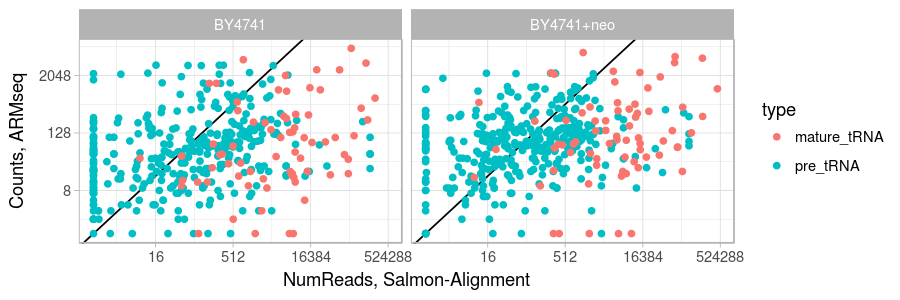

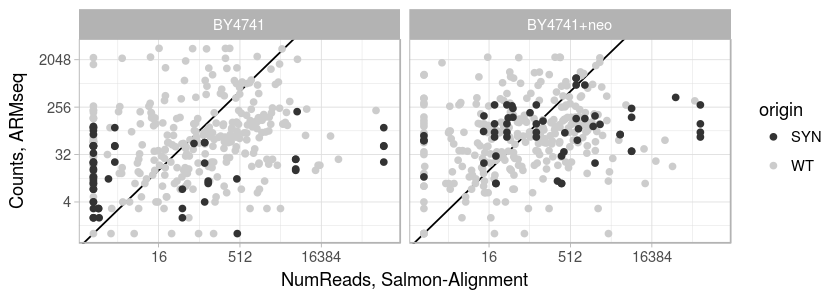

In [50]:
options(repr.plot.width = 7.5)
options(repr.plot.height = 2.5)
p12.1
options(repr.plot.width = 7.)
options(repr.plot.height = 2.5)
p12.2

In [51]:
combined %>% filter(quanttype%in%c("align",NA), sample == "S2", grepl("tRNA", type)) %>% ungroup() %>% group_by(origin) %>% 
    select(Name, NumReads, armseq) %>% drop_na() %>%
    summarize(Salmon_mean = mean(NumReads, na.rm=T),
              Salmon_lt_1 = sum(NumReads < 1, na.rm = T),
              ARMseq_mean = mean(armseq, na.rm = T),
              ARMseq_lt_1 = sum(armseq < 1, na.rm = T),
              Num_species = length(NumReads)
            )

Adding missing grouping variables: `origin`


origin,Salmon_mean,Salmon_lt_1,ARMseq_mean,ARMseq_lt_1,Num_species
BY4741_neo,25194.907,0,506.15493,4,71
SYN,16930.224,32,32.03509,1,57
WT,1424.541,32,269.76370,6,292


** Conclusions ** 

- ARM-seq quantifies nearly all SYN transcripts at level >= 1 read, even in BY4741 where they are not present
- Furthermore, ARM-seq quantifies at <1 read several mature tRNAs and WT pre-tRNAs, whereas Salmon doesn not.
- However, when Salmon does misquantify a pre-tRNA it suffers from extreme overestimation, whereas ARMseq quantifies all of these species at low level

## ARMseq quantification distribution

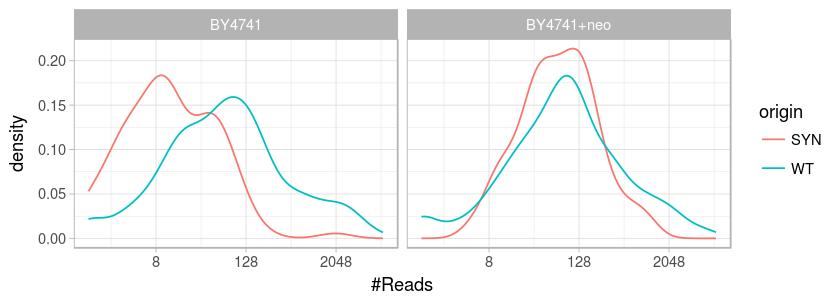

In [115]:
p13 <- ggplot(armseq %>% filter(grepl("tRNA",name), 
                                 !grepl("wholecounts|fiveprime|threeprime|other",name)) %>% 
               mutate(origin = ifelse(grepl("chr18",name),"SYN","WT")), 
               aes(armseq+1,  color=origin)) + 
    geom_freqpoly(stat ="density") +
    scale_x_continuous(trans="log2") +
    facet_wrap(~ezsample) +
    xlab("#Reads") +
    theme_light()
options(repr.plot.width = 7.)
options(repr.plot.height = 2.5)
p13

** Conclusions ** 

- ARMseq quantifications are >0 for SYN pre-tRNA species, even in absence of neochr
- There is a shift towards higher expression in +neo strain
- Distributions look worse than quasi alignment

# Differential expression with Salmon-alignment

In [134]:
file.path(BASE, "salmon_align_mode/align", c("2016-08-19-HG3W5AFXX-S1"))

[1] "/g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/salmon_align_mode/align/2016-08-19-HG3W5AFXX-S1"

In [136]:
# dataf1 = file.path(BASE, "/salmon_align_mode/align/2016-08-19-HG3W5AFXX-S1/quant.sf")
# salmon_align_1 = read_delim(dataf1, delim="\t") %>% mutate(sample = "S1", quanttype = "align")
# dataf2 = file.path(BASE, "/salmon_align_mode/align/2016-08-19-HG3W5AFXX-S2/quant.sf")
# salmon_align_2 = read_delim(dataf2, delim="\t") %>% mutate(sample = "S2", quanttype = "align")
# salmon_align = rbind(salmon_align_1, salmon_align_2)

sr = file.path(BASE, "/salmon_align_mode/sleuth_results.rda")
rerun = T
if (!file.exists(sr) | rerun) {
    cat("Running sleuth\n\n")
    salmondirs <- file.path(BASE, "salmon_align_mode/align", c("2016-08-19-HG3W5AFXX-S1",
                                                               "2016-08-19-HG3W5AFXX-S2",
                                                               "2016-08-19-HG3W5AFXX-S3",
                                                               "2016-08-19-HG3W5AFXX-S4"))
    for (i in salmondirs) {
        if (file.exists(file.path(i,"abundance.h5"))) {
            file.remove(file.path(i,"abundance.h5"))
        }
    }
    
    prepare_fish_for_sleuth(salmondirs)
    synT = data.frame(
        sample = c("BY4741+neo", "BY4741", "triple-syn+neo", "triple-syn"),
        condition1 = c("wt", "wt", "syn", "syn"),
        condition2 = c("neo+", "neo-", "neo+", "neo-"),
        path = c(file.path(BASE, "salmon_align_mode/align", c("2016-08-19-HG3W5AFXX-S1")),
                file.path(BASE, "salmon_align_mode/align", c("2016-08-19-HG3W5AFXX-S2")),
                file.path(BASE, "salmon_align_mode/align", c("2016-08-19-HG3W5AFXX-S3")),
                file.path(BASE, "salmon_align_mode/align", c("2016-08-19-HG3W5AFXX-S4"))),
        stringsAsFactors = F
    )
    so <- sleuth_prep(synT, ~ condition1 + condition2)
    so <- sleuth_fit(so)
    so <- sleuth_fit(so, ~1, 'reduced')
    so <- sleuth_lrt(so, 'reduced', 'full')
    results_table <- sleuth_results(so, 'reduced:full', test_type = 'lrt')
    save(so, results_table, file = sr)
} else {
    load(sr)
}

Running sleuth



Since salmon was run in alignment mode, it is recommended you provide the total number of input reads via the fallback_num_reads argument to prepare_fish_for_sleuth()


Thu Aug  2 17:43:26 2018
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/salmon_align_mode/align/2016-08-19-HG3W5AFXX-S1 to kallisto HDF5 format"


Since salmon was run in alignment mode, it is recommended you provide the total number of input reads via the fallback_num_reads argument to prepare_fish_for_sleuth()


Thu Aug  2 17:43:28 2018
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/salmon_align_mode/align/2016-08-19-HG3W5AFXX-S2 to kallisto HDF5 format"


Since salmon was run in alignment mode, it is recommended you provide the total number of input reads via the fallback_num_reads argument to prepare_fish_for_sleuth()


Thu Aug  2 17:43:29 2018
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/salmon_align_mode/align/2016-08-19-HG3W5AFXX-S3 to kallisto HDF5 format"


Since salmon was run in alignment mode, it is recommended you provide the total number of input reads via the fallback_num_reads argument to prepare_fish_for_sleuth()


Thu Aug  2 17:43:31 2018
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/salmon_align_mode/align/2016-08-19-HG3W5AFXX-S4 to kallisto HDF5 format"


reading in kallisto results
dropping unused factor levels
....
normalizing est_counts
627 targets passed the filter
normalizing tpm
merging in metadata
summarizing bootstraps

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [139]:
rf = file.path(BASE, "salmon_align_mode/align","all_results.rds")
rerun = F
if (!file.exists(rf) | rerun) {
    results = salmon_align
    cat("Merging and saving\n")
    results = merge(results, results_table, by.x = "Name.original", by.y = "target_id", all.x = T)
    results$type[grepl("tRNA",results$Name)] = "mature_tRNA"
    results$type[grepl("chr.*tRNA",results$Name)] = "pre_tRNA"
    results$type[grepl("snoRNA_gene",results$type)] = "snoRNA"
    results$type[grepl("ncRNA_gene",results$type)] = "ncRNA_other"
    results$type[grepl("snRNA_gene",results$type)] = "snRNA"
    results$type[grepl("rRNA_gene",results$type)] = "rRNA"
    results$ezseqid[which(results$type=="mature_tRNA")] = "mature"
    saveRDS(results, rf)
} else {
    results <- readRDS(rf)
}

Merging and saving


In [141]:
results %>% select(Name.original, qval) %>% distinct() %>% 
    summarise(n.sig.01 = sum(qval<.01, na.rm=T),
             n.sig.05 = sum(qval<.05, na.rm=T),
             n.sig.1 = sum(qval<.1, na.rm=T))

n.sig.01,n.sig.05,n.sig.1
0,61,102


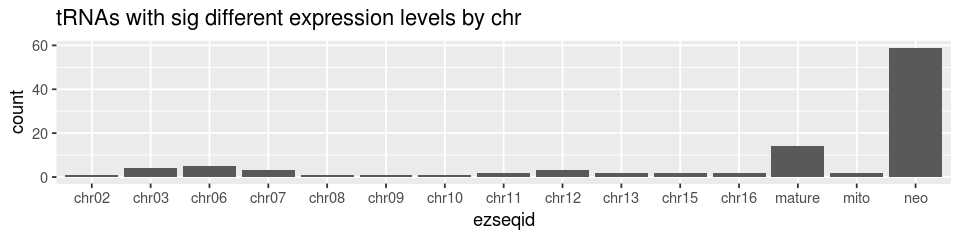

In [142]:
options(repr.plot.width = 8)
options(repr.plot.height = 2)
p6 <- ggplot(filter(results,qval<=.1) %>% select(Name,ezseqid) %>% distinct()) + geom_bar(aes(ezseqid)) +
    ggtitle("tRNAs with sig different expression levels by chr")
p6